# **Fantasy Football Rookie Analyzer**
## Purpose:
I enjoy the statistics behind fantasy football, but why is it so random? Is there method to the madness??\
Rookies provide a huge edge if you can guess which ones will be productive.\
There has to be a better way...
## Methodology:
1. Gather data from different websources
2. Train a machine learning model
3. Analyze results to see if it is possible to accurately predict if a rookie will have a statistically significant season 

## **Setup Code**

In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import re
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

Pickles are a nice way to store dfs when the notebook is exited.

In [2]:
combine = pd.read_pickle('combine.pkl')
draft = pd.read_pickle('draft.pkl')
fantasy = pd.read_pickle('fantasy.pkl')
merged = pd.read_pickle('merged.pkl')

## **Combine results from combineresults.com**
- creates combine df

In [5]:
combine

,Name,Year,Pos,Wt,Ht,40,Bench,Vert,Broad Jump,Shuttle,3Cone
0,Sam Aiken,2003,WR,209,73.90,4.64,0,39.5,121,0.00,0.00
1,Arnaz Battle,2003,WR,217,73.00,4.58,0,35.0,117,4.06,0.00
2,Santonio Beard,2003,RB,222,71.60,4.59,0,31.5,119,0.00,0.00
3,Ronald Bellamy,2003,WR,208,72.00,4.57,0,30.5,119,4.09,0.00
4,Anquan Boldin,2003,WR,216,72.60,4.73,0,33.5,114,4.25,0.00
...,...,...,...,...,...,...,...,...,...,...,...
1937,Miyan Williams,2024,RB,229,68.50,0.00,22,0.0,0,0.00,0.00
1938,Johnny Wilson,2024,WR,231,78.38,4.52,0,37.0,128,0.00,0.00
1939,Roman Wilson,2024,WR,185,70.75,4.39,12,0.0,0,4.07,6.89
1940,Xavier Worthy,2024,WR,165,71.25,4.21,0,41.0,131,0.00,0.00


### Code for scraping combine df

In [2]:
combine_columns = ['Name','Year','Pos','Wt','Ht','40','Bench','Vert','Broad Jump','Shuttle','3Cone']
combine = pd.DataFrame(columns=combine_columns)

year = 2003
while year <= 2024:
    sLink = fr'https://nflcombineresults.com/nflcombinedata.php?year={year}&pos=&college=#google-vignette'
    page = requests.get(sLink, headers={'User-Agent': 'Custom'})

    soup = BeautifulSoup(page.content, 'html.parser')

    rows = soup.find_all('tr')
    
    column_names = [col.text for col in rows[0].find_all('td')]
    rows = rows[1:]

    for row in rows:
        player = []
        row = row.find_all('td')
        if len(row) != 13 or row[3].text not in ['RB', 'WR']:
            continue
        player = []
        raw_player = [col.text if col.text != '' else 0 for col in row]
        player.append(raw_player[1])
        player.append(int(raw_player[0]))
        player.append(raw_player[3])
        player.append(int(raw_player[5]))
        player.append(float(raw_player[4]))
        player.append(float(raw_player[7]))
        player.append(int(raw_player[8]))
        player.append(float(raw_player[9]))
        player.append(int(raw_player[10]))
        player.append(float(raw_player[11]))
        player.append(float(raw_player[12]))
        combine.loc[len(combine.index)] = player

    year += 1

In [3]:
combine

,Name,Year,Pos,Wt,Ht,40,Bench,Vert,Broad Jump,Shuttle,3Cone
0,Sam Aiken,2003,WR,209,73.90,4.64,0,39.5,121,0.00,0.00
1,Arnaz Battle,2003,WR,217,73.00,4.58,0,35.0,117,4.06,0.00
2,Santonio Beard,2003,RB,222,71.60,4.59,0,31.5,119,0.00,0.00
3,Ronald Bellamy,2003,WR,208,72.00,4.57,0,30.5,119,4.09,0.00
4,Anquan Boldin,2003,WR,216,72.60,4.73,0,33.5,114,4.25,0.00
...,...,...,...,...,...,...,...,...,...,...,...
1937,Miyan Williams,2024,RB,229,68.50,0.00,22,0.0,0,0.00,0.00
1938,Johnny Wilson,2024,WR,231,78.38,4.52,0,37.0,128,0.00,0.00
1939,Roman Wilson,2024,WR,185,70.75,4.39,12,0.0,0,4.07,6.89
1940,Xavier Worthy,2024,WR,165,71.25,4.21,0,41.0,131,0.00,0.00


In [4]:
combine.to_pickle('combine.pkl')

## **Draft data from drafthistory.com**
- creates draft df

In [4]:
draft

,Name,Pos,Year,Round,Pick,Number,Team,College
0,Jonathon Brooks,RB,2024,2,46,1,Panthers,Texas
1,Trey Benson,RB,2024,3,66,2,Cardinals,Florida State
2,Blake Corum,RB,2024,3,83,3,Rams,Michigan
3,MarShawn Lloyd,RB,2024,3,88,4,Packers,USC
4,Jaylen Wright,RB,2024,4,120,5,Dolphins,Tennessee
...,...,...,...,...,...,...,...,...
1198,DeAndrew Rubin,WR,2003,7,253,33,Packers,South Florida
1199,Kevin Walter,WR,2003,7,255,34,Giants,Eastern Michigan
1200,Carl Ford,WR,2003,7,256,35,Packers,Toledo
1201,Travis Anglin,WR,2003,7,260,36,Lions,Memphis


### Code for scraping draft df

In [9]:
draft_columns = ['Name','Pos','Year','Round','Pick','Number','Team','College']
draft = pd.DataFrame(columns=draft_columns)

sLink = fr'https://www.drafthistory.com/index.php/positions/rb'
page = requests.get(sLink, headers={'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/129.0.0.0 Safari/537.36'})
page.status_code

200

In [10]:
soup = BeautifulSoup(page.content, 'html.parser')
rows = soup.find_all('tr')
rows = rows[2:]

In [11]:
year = 0
for row in rows:
    cols = row.find_all('td')
    cols = [col.text for col in cols]
    if 's' in cols[0]:
        continue
    if cols[0] != '\xa0':
        year = int(cols[0])
    if year == 2002:
        break
    player = []
    player.append(cols[5])
    player.append('RB')
    player.append(year)
    player.append(int(cols[2]))
    player.append(int(cols[4]))
    player.append(int(cols[1]))
    player.append(cols[6])
    player.append(cols[7])  

    draft.loc[len(draft.index)] = player

In [12]:
draft

,Name,Pos,Year,Round,Pick,Number,Team,College
0,Jonathon Brooks,RB,2024,2,46,1,Panthers,Texas
1,Trey Benson,RB,2024,3,66,2,Cardinals,Florida State
2,Blake Corum,RB,2024,3,83,3,Rams,Michigan
3,MarShawn Lloyd,RB,2024,3,88,4,Packers,USC
4,Jaylen Wright,RB,2024,4,120,5,Dolphins,Tennessee
...,...,...,...,...,...,...,...,...
488,Andrew Pinnock,RB,2003,7,229,19,Chargers,South Carolina
489,Ahmaad Galloway,RB,2003,7,235,20,Broncos,Alabama
490,Brandon Drumm,RB,2003,7,236,21,Lions,Colorado
491,J.T. Wall,RB,2003,7,242,22,Steelers,Georgia


In [13]:
sLink = fr'https://www.drafthistory.com/index.php/positions/wr'
page = requests.get(sLink, headers={'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/129.0.0.0 Safari/537.36'})
page.status_code

200

In [14]:
soup = BeautifulSoup(page.content, 'html.parser')
rows = soup.find_all('tr')
rows = rows[2:]

In [15]:
year = 0
for row in rows:
    cols = row.find_all('td')
    cols = [col.text for col in cols]
    if 's' in cols[0]:
        continue
    if cols[0] != '\xa0':
        year = int(cols[0])
    if year == 2002:
        break
    player = []
    player.append(cols[5])
    player.append('WR')
    player.append(year)
    player.append(int(cols[2]))
    player.append(int(cols[4]))
    player.append(int(cols[1]))
    player.append(cols[6])
    player.append(cols[7])  

    draft.loc[len(draft.index)] = player

In [16]:
draft

,Name,Pos,Year,Round,Pick,Number,Team,College
0,Jonathon Brooks,RB,2024,2,46,1,Panthers,Texas
1,Trey Benson,RB,2024,3,66,2,Cardinals,Florida State
2,Blake Corum,RB,2024,3,83,3,Rams,Michigan
3,MarShawn Lloyd,RB,2024,3,88,4,Packers,USC
4,Jaylen Wright,RB,2024,4,120,5,Dolphins,Tennessee
...,...,...,...,...,...,...,...,...
1198,DeAndrew Rubin,WR,2003,7,253,33,Packers,South Florida
1199,Kevin Walter,WR,2003,7,255,34,Giants,Eastern Michigan
1200,Carl Ford,WR,2003,7,256,35,Packers,Toledo
1201,Travis Anglin,WR,2003,7,260,36,Lions,Memphis


In [17]:
draft.to_pickle('draft.pkl')

## **Fantasy data from fantasydata.com**
- creates fantasy df

In [6]:
fantasy

,Name,Pos,Year,FPTS,FPTS/G,GP
0,Randy Moss,WR,2003,376.0,23.5,16
1,Torry Holt,WR,2003,359.1,22.4,16
2,Chad Johnson,WR,2003,285.5,17.8,16
3,Anquan Boldin,WR,2003,282.7,17.7,16
4,Marvin Harrison,WR,2003,277.5,18.5,15
...,...,...,...,...,...,...
8795,C.J. Ham,FB,2024,8.1,0.8,10
8796,Deuce Vaughn,RB,2024,8.1,1.3,6
8797,Kendre Miller,RB,2024,7.3,3.6,2
8798,Jeff Wilson Jr.,RB,2024,7.2,1.4,5


### Code for creating fantasy df

In [18]:
fantasy_columns = ['Name','Pos','Year','FPTS','FPTS/G','GP']
fantasy = pd.DataFrame(columns=fantasy_columns)

In [19]:
for pos in ['wr','rb']:
    year = 2003
    page = 1
    while year <= 2024:
        for page_index in range(1,3):
            sLink = fr'https://fantasydata.com/nfl/fantasy-football-leaders?scope=season&sp={year}_REG&position={pos}&scoring=fpts_ppr&order_by=fpts_ppr&sort_dir=desc&page={page_index}'
            page = requests.get(sLink, headers={'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/129.0.0.0 Safari/537.36'})
            soup = BeautifulSoup(page.content, 'html.parser')
            rows = soup.find_all('tr')
            rows = rows[2:]
            for row in rows:
                cols = row.find_all('td')
                flag = False
                if cols[0].text == '100' or cols[0].text == '150':
                    flag = True
                try:
                    player = []
                    player.append(cols[1].text)
                    player.append(cols[3].text)
                    player.append(year)
                    if pos == 'wr':
                        player.append(float(cols[20].text))
                        player.append(float(cols[19].text))
                    else:
                        player.append(float(cols[16].text))
                        player.append(float(cols[15].text))
                    player.append(int(cols[4].text))
                    fantasy.loc[len(fantasy.index)] = player
                except:
                    print(f'Error at {year}, {pos}, {page_index}')
                
                if flag:
                    break
        year += 1

In [20]:
fantasy

,Name,Pos,Year,FPTS,FPTS/G,GP
0,Randy Moss,WR,2003,376.0,23.5,16
1,Torry Holt,WR,2003,359.1,22.4,16
2,Chad Johnson,WR,2003,285.5,17.8,16
3,Anquan Boldin,WR,2003,282.7,17.7,16
4,Marvin Harrison,WR,2003,277.5,18.5,15
...,...,...,...,...,...,...
8795,C.J. Ham,FB,2024,8.1,0.8,10
8796,Deuce Vaughn,RB,2024,8.1,1.3,6
8797,Kendre Miller,RB,2024,7.3,3.6,2
8798,Jeff Wilson Jr.,RB,2024,7.2,1.4,5


In [21]:
fantasy.to_pickle('fantasy.pkl')

## **Merge**
- merges combine, draft, and fantasy dataframes
- creates merged df

In [8]:
merged

,Name,Pos,Year,Round,Pick,Number,Team,College,Wt,Ht,40,Bench,Vert,Broad Jump,Shuttle,3Cone,FPTS,FPTS/G,GP
0,Trey Benson,RB,2024,3,66,2,Cardinals,Florida State,216,72.25,4.39,23,33.5,122,0.00,0.00,38.1,4.2,9
2,Blake Corum,RB,2024,3,83,3,Rams,Michigan,205,67.75,4.53,27,35.5,0,4.12,6.82,17.2,1.7,10
4,Jaylen Wright,RB,2024,4,120,5,Dolphins,Tennessee,210,70.50,4.38,0,38.0,134,0.00,0.00,22.7,2.5,9
6,Bucky Irving,RB,2024,4,125,6,Buccaneers,Oregon,192,69.00,4.55,15,29.5,115,0.00,0.00,116.0,11.6,10
8,Ray Davis,RB,2024,4,128,8,Bills,Kentucky,211,68.38,4.52,21,35.0,119,4.51,0.00,70.8,6.4,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786,Bernard Berrian,WR,2004,3,78,12,Bears,Fresno State,183,73.00,4.58,0,38.0,128,4.18,0.00,52.3,3.3,16
788,Andre Johnson,WR,2003,1,3,2,Texans,Miami (FL),230,74.00,4.40,0,39.0,132,0.00,0.00,186.6,11.7,16
790,Anquan Boldin,WR,2003,2,54,6,Cardinals,Florida State,216,72.60,4.73,0,33.5,114,4.25,0.00,282.7,17.7,16
792,Nate Burleson,WR,2003,3,71,10,Vikings,Nevada,197,73.00,4.51,0,42.5,126,4.16,0.00,84.5,5.3,16


### Code to merge combine, draft, and fantasy dfs

In [4]:
temp = pd.merge(draft, combine, on=['Name'])

In [5]:
temp[(temp['Pos_x'] != temp['Pos_y']) & (temp['Year_x'] == temp['Year_y'])]

,Name,Pos_x,Year_x,Round,Pick,Number,Team,College,Year_y,Pos_y,Wt,Ht,40,Bench,Vert,Broad Jump,Shuttle,3Cone
192,Dri Archer,RB,2014,3,97,8,Steelers,Kent State,2014,WR,173,67.75,4.26,20,38.0,122,4.06,0.00
270,Dexter McCluster,RB,2010,2,36,4,Chiefs,Mississippi,2010,WR,172,68.75,4.53,20,37.5,118,4.06,6.73
278,Trindon Holliday,RB,2010,6,197,14,Texans,Louisiana State,2010,WR,166,65.25,4.21,10,42.0,116,4.48,0.00
504,Antonio Gibson,WR,2020,3,66,14,Redskins,Memphis,2020,RB,228,72.38,4.39,16,35.0,118,0.00,0.00
505,Lynn Bowden,WR,2020,3,80,15,Raiders,Kentucky,2020,RB,204,70.63,0.00,13,0.0,0,0.00,0.00
525,Malcolm Perry,WR,2020,7,246,36,Dolphins,Navy,2020,RB,186,69.50,4.63,10,36.0,122,4.31,0.00
935,Marques Hagans,WR,2006,5,144,19,Rams,Virginia,2006,RB,202,69.38,4.64,0,35.0,114,4.38,6.88


dri -> RB
dexter -> RB
trindon -> WR
Gibson -> RB
Bowden -> WR
Perry -> RB
Hagans -> WR

In [6]:
temp.loc[278,'Pos_x'] = 'WR'
temp.loc[504,'Pos_x'] = 'RB'
temp.loc[525,'Pos_x'] = 'RB'

In [7]:
temp.drop('Year_y', axis=1, inplace=True)
temp.drop('Pos_y', axis=1, inplace=True)
temp.rename(columns={'Pos_x': 'Pos'}, inplace=True)
temp.rename(columns={'Year_x': 'Year'}, inplace=True)

In [8]:
temp

,Name,Pos,Year,Round,Pick,Number,Team,College,Wt,Ht,40,Bench,Vert,Broad Jump,Shuttle,3Cone
0,Jonathon Brooks,RB,2024,2,46,1,Panthers,Texas,216,72.38,0.00,0,0.0,0,0.00,0.00
1,Trey Benson,RB,2024,3,66,2,Cardinals,Florida State,216,72.25,4.39,23,33.5,122,0.00,0.00
2,Blake Corum,RB,2024,3,83,3,Rams,Michigan,205,67.75,4.53,27,35.5,0,4.12,6.82
3,MarShawn Lloyd,RB,2024,3,88,4,Packers,USC,220,68.75,4.46,25,36.0,118,0.00,0.00
4,Jaylen Wright,RB,2024,4,120,5,Dolphins,Tennessee,210,70.50,4.38,0,38.0,134,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1010,Kareem Kelly,WR,2003,6,203,27,Saints,USC,186,71.80,4.43,0,35.0,125,4.14,0.00
1011,Keenan Howry,WR,2003,7,221,29,Vikings,Oregon,178,69.60,4.62,0,31.5,114,4.24,0.00
1012,Walter Young,WR,2003,7,226,31,Panthers,Illinois,214,76.60,4.59,0,39.0,121,4.22,0.00
1013,Talman Gardner,WR,2003,7,231,32,Saints,Florida State,205,72.60,4.47,0,34.5,116,4.41,0.00


In [10]:
merged = pd.merge(temp, fantasy, on=['Name','Pos','Year']).drop_duplicates()

In [11]:
merged

,Name,Pos,Year,Round,Pick,Number,Team,College,Wt,Ht,40,Bench,Vert,Broad Jump,Shuttle,3Cone,FPTS,FPTS/G,GP
0,Trey Benson,RB,2024,3,66,2,Cardinals,Florida State,216,72.25,4.39,23,33.5,122,0.00,0.00,38.1,4.2,9
2,Blake Corum,RB,2024,3,83,3,Rams,Michigan,205,67.75,4.53,27,35.5,0,4.12,6.82,17.2,1.7,10
4,Jaylen Wright,RB,2024,4,120,5,Dolphins,Tennessee,210,70.50,4.38,0,38.0,134,0.00,0.00,22.7,2.5,9
6,Bucky Irving,RB,2024,4,125,6,Buccaneers,Oregon,192,69.00,4.55,15,29.5,115,0.00,0.00,116.0,11.6,10
8,Ray Davis,RB,2024,4,128,8,Bills,Kentucky,211,68.38,4.52,21,35.0,119,4.51,0.00,70.8,6.4,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786,Bernard Berrian,WR,2004,3,78,12,Bears,Fresno State,183,73.00,4.58,0,38.0,128,4.18,0.00,52.3,3.3,16
788,Andre Johnson,WR,2003,1,3,2,Texans,Miami (FL),230,74.00,4.40,0,39.0,132,0.00,0.00,186.6,11.7,16
790,Anquan Boldin,WR,2003,2,54,6,Cardinals,Florida State,216,72.60,4.73,0,33.5,114,4.25,0.00,282.7,17.7,16
792,Nate Burleson,WR,2003,3,71,10,Vikings,Nevada,197,73.00,4.51,0,42.5,126,4.16,0.00,84.5,5.3,16


In [12]:
merged.to_pickle('merged.pkl')

## **RB Model**

### Visualizations

In [108]:
rbs

,Name,Pos,Year,Round,Pick,Number,Team,College,Wt,Ht,40,Bench,Vert,Broad Jump,Shuttle,3Cone,FPTS,FPTS/G,GP
18,Bijan Robinson,RB,2023,1,8,1,Falcons,Texas,215,71.00,4.46,0,37.0,124,0.00,0.00,246.3,14.5,17
20,Jahmyr Gibbs,RB,2023,1,12,2,Lions,Alabama,199,69.13,4.36,0,33.5,0,0.00,0.00,242.1,16.1,15
22,Zach Charbonnet,RB,2023,2,52,3,Seahawks,UCLA,222,72.38,4.53,18,37.0,122,4.46,7.16,106.1,6.6,16
24,Kendre Miller,RB,2023,3,71,4,Saints,Texas Christian,215,71.13,0.00,0,0.0,0,0.00,0.00,43.3,5.4,8
26,Tyjae Spears,RB,2023,3,81,5,Titans,Tulane,201,69.63,4.54,18,39.0,125,4.32,7.27,153.8,9.0,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398,Mewelde Moore,RB,2004,4,119,7,Vikings,Tulane,209,70.60,4.62,0,35.0,118,4.12,0.00,88.7,8.9,10
400,Chris Brown,RB,2003,3,93,5,Titans,Colorado,210,70.38,4.55,17,36.0,115,4.49,7.12,36.2,3.3,11
402,Chris Brown,RB,2003,3,93,5,Titans,Colorado,194,74.00,4.50,14,33.5,130,4.41,7.37,36.2,3.3,11
404,Domanick Davis,RB,2003,4,101,8,Texans,Louisiana State,213,69.00,4.64,22,32.5,112,4.46,0.00,227.2,16.2,14


In [109]:
checkForZeros()

Wt: 0
Ht: 0
40: 8
Bench: 40
Vert: 11
Broad Jump: 19
Shuttle: 46
3Cone: 137
FPTS: 0
FPTS/G: 0
GP: 0


In [116]:
rbs

,Name,Pos,Year,Round,Pick,Number,Team,College,Wt,Ht,40,Bench,Vert,Broad Jump,Shuttle,FPTS,FPTS/G,GP
18,Bijan Robinson,RB,2023,1,8,1,Falcons,Texas,215,71.00,4.46,19,37.0,124,4.27,246.3,14.5,17
20,Jahmyr Gibbs,RB,2023,1,12,2,Lions,Alabama,199,69.13,4.36,19,33.5,120,4.27,242.1,16.1,15
22,Zach Charbonnet,RB,2023,2,52,3,Seahawks,UCLA,222,72.38,4.53,18,37.0,122,4.46,106.1,6.6,16
24,Kendre Miller,RB,2023,3,71,4,Saints,Texas Christian,215,71.13,4.51,19,35.2,120,4.27,43.3,5.4,8
26,Tyjae Spears,RB,2023,3,81,5,Titans,Tulane,201,69.63,4.54,18,39.0,125,4.32,153.8,9.0,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398,Mewelde Moore,RB,2004,4,119,7,Vikings,Tulane,209,70.60,4.62,19,35.0,118,4.12,88.7,8.9,10
400,Chris Brown,RB,2003,3,93,5,Titans,Colorado,210,70.38,4.55,17,36.0,115,4.49,36.2,3.3,11
402,Chris Brown,RB,2003,3,93,5,Titans,Colorado,194,74.00,4.50,14,33.5,130,4.41,36.2,3.3,11
404,Domanick Davis,RB,2003,4,101,8,Texans,Louisiana State,213,69.00,4.64,22,32.5,112,4.46,227.2,16.2,14


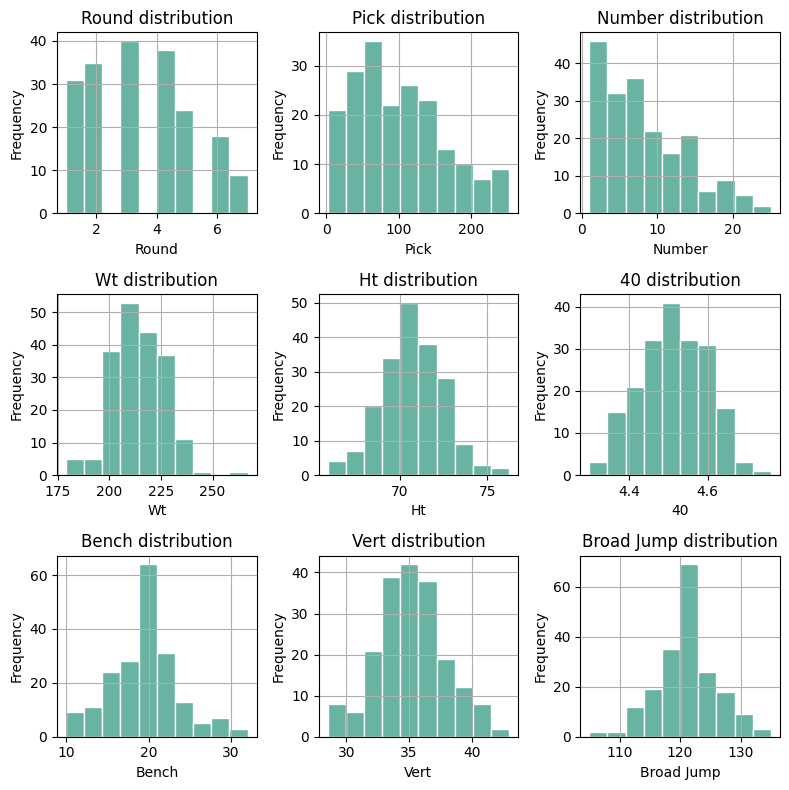

In [56]:
train_cols = ['Round','Pick','Number','Wt','Ht','40','Bench','Vert','Broad Jump','Shuttle','FPTS','FPTS/G']
fig, axes = plt.subplots(3, 3, figsize=(8,8))
axes = axes.flatten()
for i, column in enumerate(rbs[train_cols[:9]]):
    rbs[column].hist(ax=axes[i], edgecolor='white',color='#69b3a2')
    axes[i].set_title(f'{column} distribution') 
    axes[i].set_xlabel(column) 
    axes[i].set_ylabel('Frequency') 
    
plt.tight_layout()
plt.show()

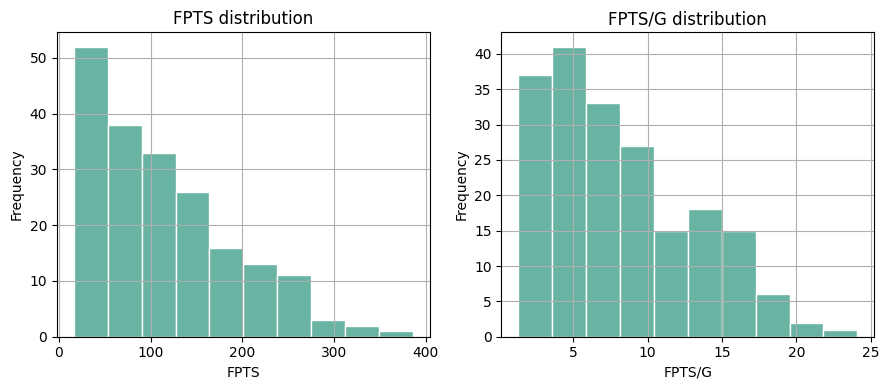

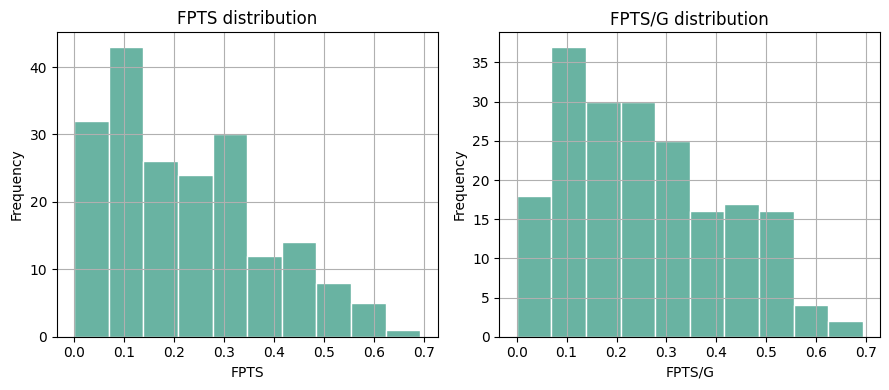

In [65]:
train_cols = ['FPTS','FPTS/G']
fig, axes = plt.subplots(1, 2, figsize=(9,4))
axes = axes.flatten()
for i, column in enumerate(rbs[train_cols]):
    rbs[column].hist(ax=axes[i], edgecolor='white',color='#69b3a2')
    axes[i].set_title(f'{column} distribution') 
    axes[i].set_xlabel(column) 
    axes[i].set_ylabel('Frequency') 
    
plt.tight_layout()
plt.show()
train_cols = ['FPTS','FPTS/G']
fig, axes = plt.subplots(1, 2, figsize=(9,4))
axes = axes.flatten()
for i, column in enumerate(rbs_scaled[train_cols]):
    rbs_scaled[column].hist(ax=axes[i], edgecolor='white',color='#69b3a2')
    axes[i].set_title(f'{column} distribution') 
    axes[i].set_xlabel(column) 
    axes[i].set_ylabel('Frequency') 
    
plt.tight_layout()
plt.show()

In [118]:
rbs_scaled

,Round,Pick,Number,Wt,Ht,40,Bench,Vert,Broad Jump,Shuttle,FPTS,FPTS/G
0,0.000000,0.024,0.000000,0.409091,0.493732,0.347826,0.409091,0.586207,0.633333,0.492754,0.622463,0.578947
1,0.000000,0.040,0.041667,0.227273,0.313404,0.130435,0.409091,0.344828,0.500000,0.492754,0.611096,0.649123
2,0.166667,0.200,0.083333,0.488636,0.626808,0.500000,0.363636,0.586207,0.566667,0.768116,0.243031,0.232456
3,0.333333,0.276,0.125000,0.409091,0.506268,0.456522,0.409091,0.462069,0.500000,0.492754,0.073072,0.179825
4,0.333333,0.316,0.166667,0.250000,0.361620,0.521739,0.363636,0.724138,0.666667,0.565217,0.372124,0.337719
...,...,...,...,...,...,...,...,...,...,...,...,...
190,0.500000,0.468,0.250000,0.340909,0.455159,0.695652,0.409091,0.448276,0.433333,0.275362,0.195940,0.333333
191,0.333333,0.364,0.166667,0.352273,0.433944,0.543478,0.318182,0.517241,0.333333,0.811594,0.053857,0.087719
192,0.333333,0.364,0.166667,0.170455,0.783028,0.434783,0.181818,0.344828,0.833333,0.695652,0.053857,0.087719
193,0.500000,0.396,0.291667,0.386364,0.300868,0.739130,0.545455,0.275862,0.233333,0.768116,0.570771,0.653509


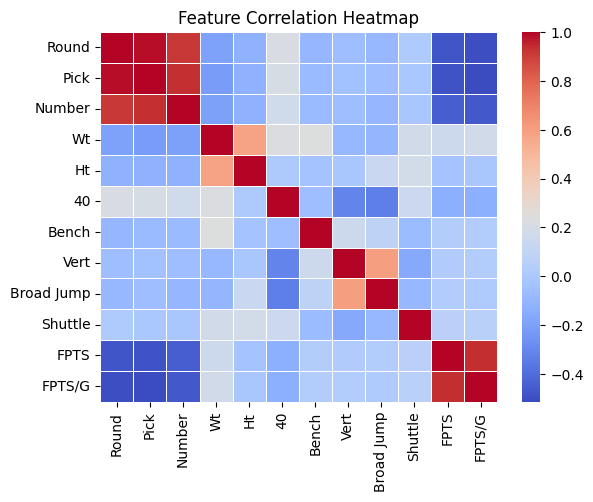

In [68]:
sns.heatmap(rbs_scaled.corr(), fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.show()

In [66]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")

Mean Squared Error (MSE): 0.055179228985412665
R² Score: -0.15450429916381836


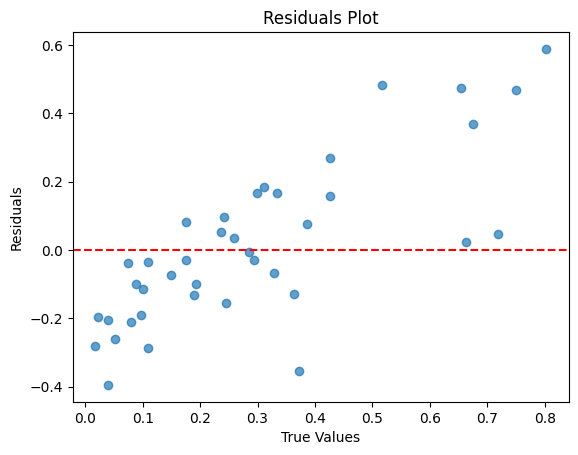

In [94]:
from sklearn.metrics import mean_squared_error
residuals = y_test.to_numpy().flat - y_pred
plt.scatter(y_test.to_numpy().flat, residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('True Values')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

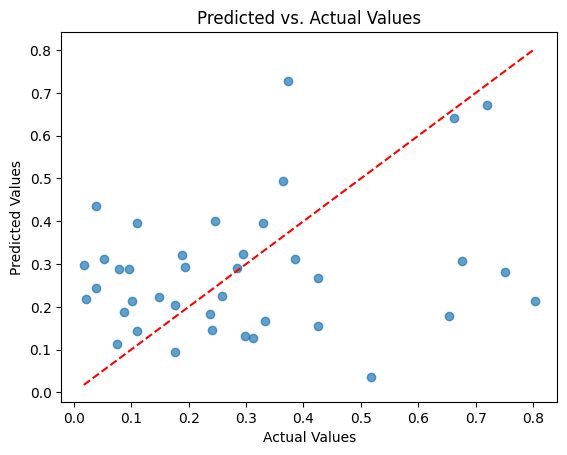

In [101]:
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. Actual Values')
plt.show()

### Code

In [107]:
rbs = merged.loc[(merged['Pos'] == 'RB') & (merged['Year'] != 2024)]


In [10]:
rbs

,Name,Pos,Year,Round,Pick,Number,Team,College,Wt,Ht,40,Bench,Vert,Broad Jump,Shuttle,3Cone,FPTS,FPTS/G,GP
18,Bijan Robinson,RB,2023,1,8,1,Falcons,Texas,215,71.00,4.46,0,37.0,124,0.00,0.00,246.3,14.5,17
20,Jahmyr Gibbs,RB,2023,1,12,2,Lions,Alabama,199,69.13,4.36,0,33.5,0,0.00,0.00,242.1,16.1,15
22,Zach Charbonnet,RB,2023,2,52,3,Seahawks,UCLA,222,72.38,4.53,18,37.0,122,4.46,7.16,106.1,6.6,16
24,Kendre Miller,RB,2023,3,71,4,Saints,Texas Christian,215,71.13,0.00,0,0.0,0,0.00,0.00,43.3,5.4,8
26,Tyjae Spears,RB,2023,3,81,5,Titans,Tulane,201,69.63,4.54,18,39.0,125,4.32,7.27,153.8,9.0,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398,Mewelde Moore,RB,2004,4,119,7,Vikings,Tulane,209,70.60,4.62,0,35.0,118,4.12,0.00,88.7,8.9,10
400,Chris Brown,RB,2003,3,93,5,Titans,Colorado,210,70.38,4.55,17,36.0,115,4.49,7.12,36.2,3.3,11
402,Chris Brown,RB,2003,3,93,5,Titans,Colorado,194,74.00,4.50,14,33.5,130,4.41,7.37,36.2,3.3,11
404,Domanick Davis,RB,2003,4,101,8,Texans,Louisiana State,213,69.00,4.64,22,32.5,112,4.46,0.00,227.2,16.2,14


In [11]:
def checkForZeros():
    for col in rbs.columns[8:]:
        counts = rbs[col].value_counts()
        try:
            print(f'{col}: {counts[0]}')
        except:
            print(f'{col}: 0')

In [12]:
checkForZeros()

Wt: 0
Ht: 0
40: 8
Bench: 40
Vert: 11
Broad Jump: 19
Shuttle: 46
3Cone: 137
FPTS: 0
FPTS/G: 0
GP: 0


In [110]:
rbs = rbs.drop('3Cone', axis=1)

In [14]:
rbs

,Name,Pos,Year,Round,Pick,Number,Team,College,Wt,Ht,40,Bench,Vert,Broad Jump,Shuttle,FPTS,FPTS/G,GP
18,Bijan Robinson,RB,2023,1,8,1,Falcons,Texas,215,71.00,4.46,0,37.0,124,0.00,246.3,14.5,17
20,Jahmyr Gibbs,RB,2023,1,12,2,Lions,Alabama,199,69.13,4.36,0,33.5,0,0.00,242.1,16.1,15
22,Zach Charbonnet,RB,2023,2,52,3,Seahawks,UCLA,222,72.38,4.53,18,37.0,122,4.46,106.1,6.6,16
24,Kendre Miller,RB,2023,3,71,4,Saints,Texas Christian,215,71.13,0.00,0,0.0,0,0.00,43.3,5.4,8
26,Tyjae Spears,RB,2023,3,81,5,Titans,Tulane,201,69.63,4.54,18,39.0,125,4.32,153.8,9.0,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398,Mewelde Moore,RB,2004,4,119,7,Vikings,Tulane,209,70.60,4.62,0,35.0,118,4.12,88.7,8.9,10
400,Chris Brown,RB,2003,3,93,5,Titans,Colorado,210,70.38,4.55,17,36.0,115,4.49,36.2,3.3,11
402,Chris Brown,RB,2003,3,93,5,Titans,Colorado,194,74.00,4.50,14,33.5,130,4.41,36.2,3.3,11
404,Domanick Davis,RB,2003,4,101,8,Texans,Louisiana State,213,69.00,4.64,22,32.5,112,4.46,227.2,16.2,14


In [111]:
fourty_mean = rbs[rbs['40'] != 0]['40'].mean()
rbs.loc[rbs['40'] == 0, '40'] = round(fourty_mean,2)
fourty_mean

np.float64(4.512299465240641)

In [112]:
bench_mean = rbs[rbs['Bench'] != 0]['Bench'].mean()
rbs.loc[rbs['Bench'] == 0, 'Bench'] = int(bench_mean)
bench_mean

np.float64(19.296774193548387)

In [113]:
vert_mean = rbs[rbs['Vert'] != 0]['Vert'].mean()
rbs.loc[rbs['Vert'] == 0, 'Vert'] = round(vert_mean, 1)
vert_mean

np.float64(35.171195652173914)

In [114]:
broad_mean = rbs[rbs['Broad Jump'] != 0]['Broad Jump'].mean()
rbs.loc[rbs['Broad Jump'] == 0, 'Broad Jump'] = int(broad_mean)
broad_mean

np.float64(120.63068181818181)

In [115]:
shuttle_mean = rbs[rbs['Shuttle'] != 0]['Shuttle'].mean()
rbs.loc[rbs['Shuttle'] == 0, 'Shuttle'] = round(shuttle_mean, 2)
shuttle_mean

np.float64(4.2739597315436235)

In [20]:
rbs

,Name,Pos,Year,Round,Pick,Number,Team,College,Wt,Ht,40,Bench,Vert,Broad Jump,Shuttle,FPTS,FPTS/G,GP
18,Bijan Robinson,RB,2023,1,8,1,Falcons,Texas,215,71.00,4.46,19,37.0,124,4.27,246.3,14.5,17
20,Jahmyr Gibbs,RB,2023,1,12,2,Lions,Alabama,199,69.13,4.36,19,33.5,120,4.27,242.1,16.1,15
22,Zach Charbonnet,RB,2023,2,52,3,Seahawks,UCLA,222,72.38,4.53,18,37.0,122,4.46,106.1,6.6,16
24,Kendre Miller,RB,2023,3,71,4,Saints,Texas Christian,215,71.13,4.51,19,35.2,120,4.27,43.3,5.4,8
26,Tyjae Spears,RB,2023,3,81,5,Titans,Tulane,201,69.63,4.54,18,39.0,125,4.32,153.8,9.0,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398,Mewelde Moore,RB,2004,4,119,7,Vikings,Tulane,209,70.60,4.62,19,35.0,118,4.12,88.7,8.9,10
400,Chris Brown,RB,2003,3,93,5,Titans,Colorado,210,70.38,4.55,17,36.0,115,4.49,36.2,3.3,11
402,Chris Brown,RB,2003,3,93,5,Titans,Colorado,194,74.00,4.50,14,33.5,130,4.41,36.2,3.3,11
404,Domanick Davis,RB,2003,4,101,8,Texans,Louisiana State,213,69.00,4.64,22,32.5,112,4.46,227.2,16.2,14


In [21]:
checkForZeros()

Wt: 0
Ht: 0
40: 0
Bench: 0
Vert: 0
Broad Jump: 0
Shuttle: 0
FPTS: 0
FPTS/G: 0
GP: 0


In [117]:
scaler = MinMaxScaler()
rbs_scaled = scaler.fit_transform(rbs[['Round','Pick','Number','Wt','Ht','40','Bench','Vert','Broad Jump','Shuttle','FPTS','FPTS/G']])
rbs_scaled = pd.DataFrame(rbs_scaled, columns=['Round','Pick','Number','Wt','Ht','40','Bench','Vert','Broad Jump','Shuttle','FPTS','FPTS/G'])
rbs_scaled

,Round,Pick,Number,Wt,Ht,40,Bench,Vert,Broad Jump,Shuttle,FPTS,FPTS/G
0,0.000000,0.024,0.000000,0.409091,0.493732,0.347826,0.409091,0.586207,0.633333,0.492754,0.622463,0.578947
1,0.000000,0.040,0.041667,0.227273,0.313404,0.130435,0.409091,0.344828,0.500000,0.492754,0.611096,0.649123
2,0.166667,0.200,0.083333,0.488636,0.626808,0.500000,0.363636,0.586207,0.566667,0.768116,0.243031,0.232456
3,0.333333,0.276,0.125000,0.409091,0.506268,0.456522,0.409091,0.462069,0.500000,0.492754,0.073072,0.179825
4,0.333333,0.316,0.166667,0.250000,0.361620,0.521739,0.363636,0.724138,0.666667,0.565217,0.372124,0.337719
...,...,...,...,...,...,...,...,...,...,...,...,...
190,0.500000,0.468,0.250000,0.340909,0.455159,0.695652,0.409091,0.448276,0.433333,0.275362,0.195940,0.333333
191,0.333333,0.364,0.166667,0.352273,0.433944,0.543478,0.318182,0.517241,0.333333,0.811594,0.053857,0.087719
192,0.333333,0.364,0.166667,0.170455,0.783028,0.434783,0.181818,0.344828,0.833333,0.695652,0.053857,0.087719
193,0.500000,0.396,0.291667,0.386364,0.300868,0.739130,0.545455,0.275862,0.233333,0.768116,0.570771,0.653509


In [23]:
X = rbs_scaled[['Round','Pick','Number','Wt','Ht','40','Bench','Vert','Broad Jump','Shuttle']]
Y_FPTS = rbs_scaled[['FPTS']]
Y_FPTS_G = rbs_scaled[['FPTS/G']]

In [24]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, Y_FPTS_G, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.3, random_state=42)

In [25]:
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',  # For regression
    n_estimators=100,             # Number of trees
    learning_rate=0.1,            # Step size shrinkage
    max_depth=3,                  # Maximum tree depth
    random_state=42               # Reproducibility
)

In [26]:
xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

[0]	validation_0-rmse:0.19197
[1]	validation_0-rmse:0.18517
[2]	validation_0-rmse:0.18005
[3]	validation_0-rmse:0.17663
[4]	validation_0-rmse:0.17343
[5]	validation_0-rmse:0.17179
[6]	validation_0-rmse:0.16985
[7]	validation_0-rmse:0.16915
[8]	validation_0-rmse:0.16759
[9]	validation_0-rmse:0.16765
[10]	validation_0-rmse:0.16684
[11]	validation_0-rmse:0.16720
[12]	validation_0-rmse:0.16666
[13]	validation_0-rmse:0.16792
[14]	validation_0-rmse:0.16775
[15]	validation_0-rmse:0.16852
[16]	validation_0-rmse:0.16924
[17]	validation_0-rmse:0.17069
[18]	validation_0-rmse:0.17121
[19]	validation_0-rmse:0.17290
[20]	validation_0-rmse:0.17459
[21]	validation_0-rmse:0.17548
[22]	validation_0-rmse:0.17623
[23]	validation_0-rmse:0.17736
[24]	validation_0-rmse:0.17875
[25]	validation_0-rmse:0.17949
[26]	validation_0-rmse:0.17962
[27]	validation_0-rmse:0.18061
[28]	validation_0-rmse:0.18110
[29]	validation_0-rmse:0.18234
[30]	validation_0-rmse:0.18301
[31]	validation_0-rmse:0.18330
[32]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [27]:
y_pred = xgb_model.predict(X_test)

In [28]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")

Mean Squared Error (MSE): 0.055179228985412665
R² Score: -0.15450429916381836


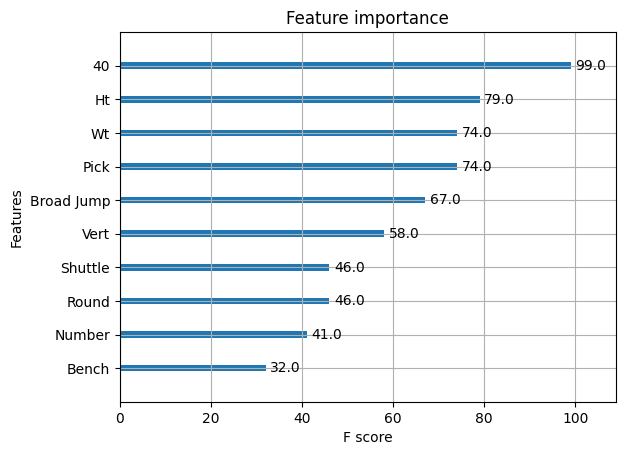

In [29]:
xgb.plot_importance(xgb_model)
plt.show()

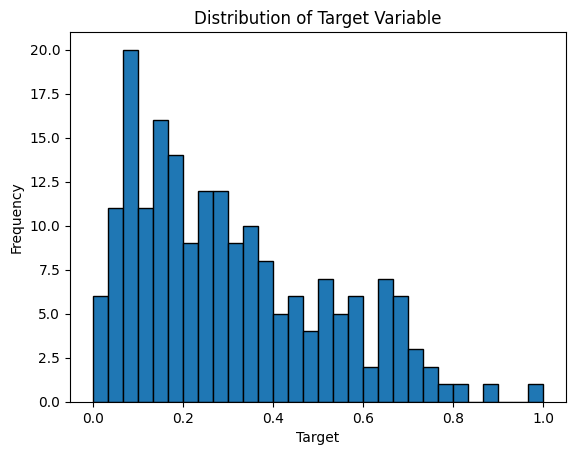

In [30]:
plt.hist(rbs_scaled[['FPTS/G']], bins=30, edgecolor='k')
plt.title('Distribution of Target Variable')
plt.xlabel('Target')
plt.ylabel('Frequency')
plt.show()

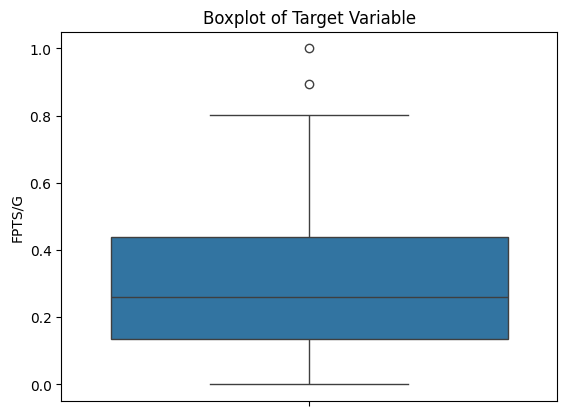

In [32]:
sns.boxplot(rbs_scaled['FPTS/G'])
plt.title('Boxplot of Target Variable')
plt.show()

In [233]:
from scipy.stats import skew

skewness = skew(rbs_scaled['FPTS/G'])
print(f"Skewness: {skewness}")

Skewness: 0.4821756373629593


In [61]:
rbs_scaled['FPTS/G'] = np.log1p(rbs_scaled['FPTS/G'])

In [62]:
rbs_scaled['FPTS'] = np.log1p(rbs_scaled['FPTS'])

In [249]:
correlation = rbs_scaled.corr()
print(correlation['FPTS/G'].sort_values(ascending=False))

FPTS/G        1.000000
FPTS          0.930983
Wt            0.172783
Shuttle       0.054891
Bench         0.028205
Vert          0.026735
Broad Jump    0.016305
Ht           -0.007729
40           -0.135157
Number       -0.468962
Round        -0.501571
Pick         -0.513270
Name: FPTS/G, dtype: float64


In [225]:
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Baseline: Predict the mean of the target variable
dummy_model = DummyRegressor(strategy="mean")
dummy_model.fit(X_train, y_train)
baseline_pred = dummy_model.predict(X_test)

# Baseline metrics
baseline_mse = mean_squared_error(y_test, baseline_pred)
baseline_r2 = r2_score(y_test, baseline_pred)
print(f"Baseline MSE: {baseline_mse}")
print(f"Baseline R²: {baseline_r2}")

Baseline MSE: 0.04847336971623321
Baseline R²: -0.014198955832150695


[0]	validation_0-rmse:0.19169
[1]	validation_0-rmse:0.18634
[2]	validation_0-rmse:0.18165
[3]	validation_0-rmse:0.17941
[4]	validation_0-rmse:0.17760
[5]	validation_0-rmse:0.17759
[6]	validation_0-rmse:0.17640
[7]	validation_0-rmse:0.17720
[8]	validation_0-rmse:0.17634
[9]	validation_0-rmse:0.17688
[10]	validation_0-rmse:0.17647
[11]	validation_0-rmse:0.17732
[12]	validation_0-rmse:0.17762
[13]	validation_0-rmse:0.17871
[14]	validation_0-rmse:0.17930
[15]	validation_0-rmse:0.18132
[16]	validation_0-rmse:0.18239
[17]	validation_0-rmse:0.18280
[18]	validation_0-rmse:0.18343
[19]	validation_0-rmse:0.18467
[20]	validation_0-rmse:0.18537
[21]	validation_0-rmse:0.18612
[22]	validation_0-rmse:0.18699
[23]	validation_0-rmse:0.18737
[24]	validation_0-rmse:0.18831
[25]	validation_0-rmse:0.18920
[26]	validation_0-rmse:0.18945
[27]	validation_0-rmse:0.19057
[28]	validation_0-rmse:0.19028
[29]	validation_0-rmse:0.19059
[30]	validation_0-rmse:0.19052
[31]	validation_0-rmse:0.19110
[32]	validation_0-

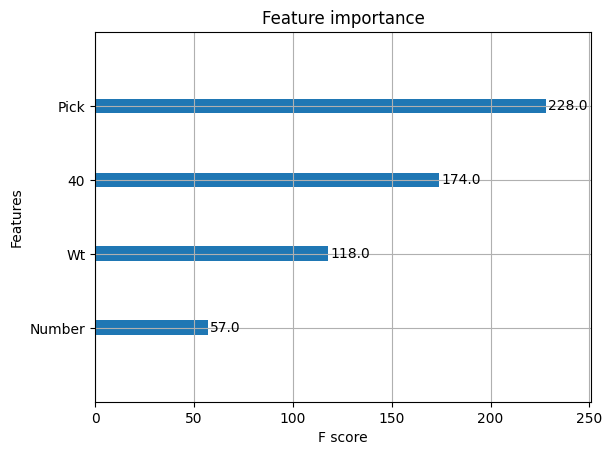

In [251]:
scaler = MinMaxScaler()
rbs_scaled = scaler.fit_transform(rbs[['Pick','Round','Number','Wt','40','FPTS','FPTS/G']])
rbs_scaled = pd.DataFrame(rbs_scaled, columns=['Pick','Round','Number','Wt','40','FPTS','FPTS/G'])
X = rbs_scaled[['Pick','Round','Number','Wt','40']]
Y_FPTS = rbs_scaled[['FPTS']]
Y_FPTS_G = rbs_scaled[['FPTS/G']]
X_train_val, X_test, y_train_val, y_test = train_test_split(X, Y_FPTS_G, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.3, random_state=42)
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',  # For regression
    n_estimators=100,             # Number of trees
    learning_rate=0.1,            # Step size shrinkage
    max_depth=3,                  # Maximum tree depth
    random_state=42               # Reproducibility
)
xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)])
y_pred = xgb_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")
xgb.plot_importance(xgb_model)
plt.show()

## **WR Model**

### Visualizations

In [123]:
wrs

,Name,Pos,Year,Round,Pick,Number,Team,College,Wt,Ht,40,Bench,Vert,Broad Jump,Shuttle,3Cone,FPTS,FPTS/G,GP
424,Jaxon Smith-Njigba,WR,2023,1,20,1,Seahawks,Ohio State,196,72.63,4.52,0,35.0,125,3.93,0.00,149.8,8.8,17
426,Quentin Johnston,WR,2023,1,21,2,Chargers,Texas Christian,208,74.75,0.00,0,40.5,134,0.00,0.00,94.0,5.5,17
428,Zay Flowers,WR,2023,1,22,3,Ravens,Boston College,182,69.25,4.42,0,35.5,127,0.00,0.00,206.4,12.9,16
430,Jordan Addison,WR,2023,1,23,4,Vikings,USC,173,71.13,4.49,0,34.0,122,4.19,7.05,221.3,13.0,17
432,Jonathan Mingo,WR,2023,2,39,5,Panthers,Mississippi,220,73.75,4.46,22,39.5,129,0.00,0.00,84.8,5.7,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786,Bernard Berrian,WR,2004,3,78,12,Bears,Fresno State,183,73.00,4.58,0,38.0,128,4.18,0.00,52.3,3.3,16
788,Andre Johnson,WR,2003,1,3,2,Texans,Miami (FL),230,74.00,4.40,0,39.0,132,0.00,0.00,186.6,11.7,16
790,Anquan Boldin,WR,2003,2,54,6,Cardinals,Florida State,216,72.60,4.73,0,33.5,114,4.25,0.00,282.7,17.7,16
792,Nate Burleson,WR,2003,3,71,10,Vikings,Nevada,197,73.00,4.51,0,42.5,126,4.16,0.00,84.5,5.3,16


In [124]:
checkForZeros()

Wt: 0
Ht: 0
40: 11
Bench: 68
Vert: 13
Broad Jump: 16
Shuttle: 36
3Cone: 124
FPTS: 0
FPTS/G: 0
GP: 0


In [127]:
wrs

,Name,Pos,Year,Round,Pick,Number,Team,College,Wt,Ht,40,Vert,Broad Jump,Shuttle,FPTS,FPTS/G,GP
424,Jaxon Smith-Njigba,WR,2023,1,20,1,Seahawks,Ohio State,196,72.63,4.52,35.0,125,3.93,149.8,8.8,17
426,Quentin Johnston,WR,2023,1,21,2,Chargers,Texas Christian,208,74.75,4.47,40.5,134,4.25,94.0,5.5,17
428,Zay Flowers,WR,2023,1,22,3,Ravens,Boston College,182,69.25,4.42,35.5,127,4.25,206.4,12.9,16
430,Jordan Addison,WR,2023,1,23,4,Vikings,USC,173,71.13,4.49,34.0,122,4.19,221.3,13.0,17
432,Jonathan Mingo,WR,2023,2,39,5,Panthers,Mississippi,220,73.75,4.46,39.5,129,4.25,84.8,5.7,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786,Bernard Berrian,WR,2004,3,78,12,Bears,Fresno State,183,73.00,4.58,38.0,128,4.18,52.3,3.3,16
788,Andre Johnson,WR,2003,1,3,2,Texans,Miami (FL),230,74.00,4.40,39.0,132,4.25,186.6,11.7,16
790,Anquan Boldin,WR,2003,2,54,6,Cardinals,Florida State,216,72.60,4.73,33.5,114,4.25,282.7,17.7,16
792,Nate Burleson,WR,2003,3,71,10,Vikings,Nevada,197,73.00,4.51,42.5,126,4.16,84.5,5.3,16


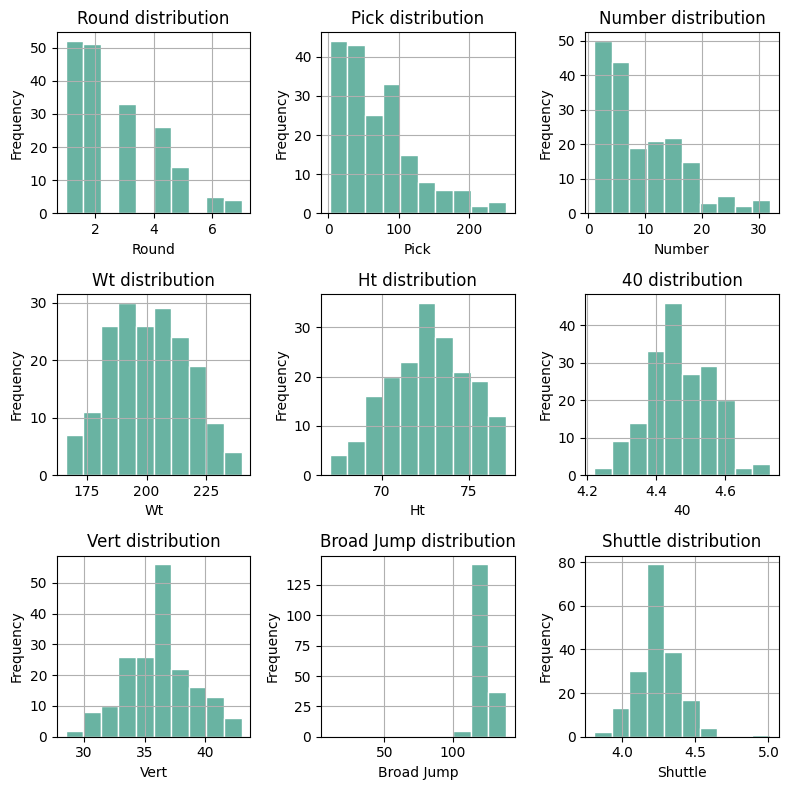

In [128]:
train_cols = ['Round','Pick','Number','Wt','Ht','40','Vert','Broad Jump','Shuttle','FPTS','FPTS/G']
fig, axes = plt.subplots(3, 3, figsize=(8,8))
axes = axes.flatten()
for i, column in enumerate(wrs[train_cols[:9]]):
    wrs[column].hist(ax=axes[i], edgecolor='white',color='#69b3a2')
    axes[i].set_title(f'{column} distribution') 
    axes[i].set_xlabel(column) 
    axes[i].set_ylabel('Frequency') 
    
plt.tight_layout()
plt.show()

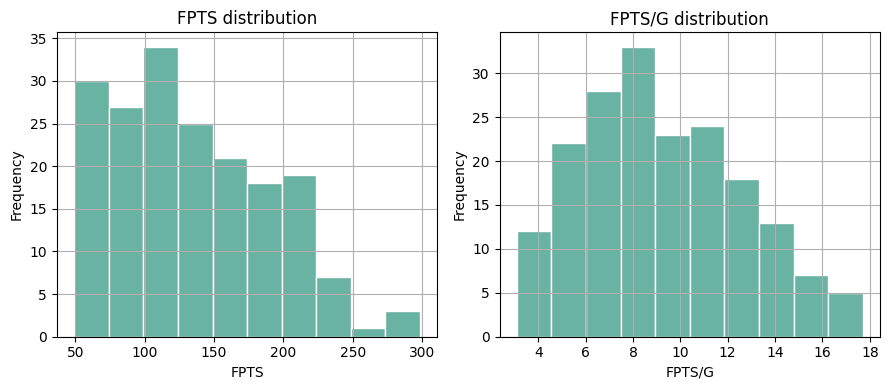

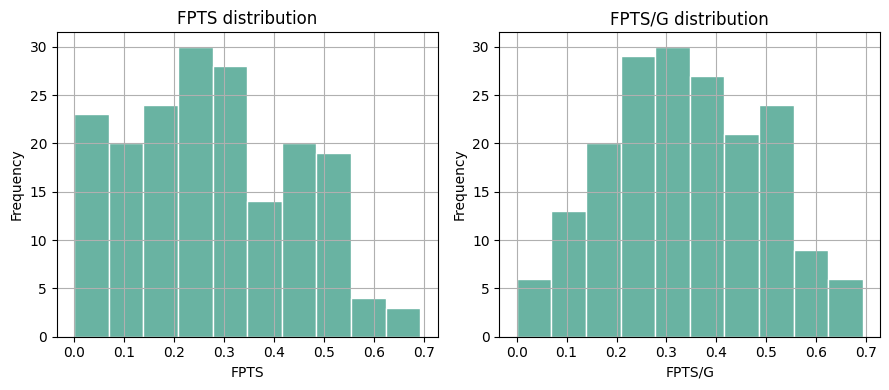

In [133]:
train_cols = ['FPTS','FPTS/G']
fig, axes = plt.subplots(1, 2, figsize=(9,4))
axes = axes.flatten()
for i, column in enumerate(wrs[train_cols]):
    wrs[column].hist(ax=axes[i], edgecolor='white',color='#69b3a2')
    axes[i].set_title(f'{column} distribution') 
    axes[i].set_xlabel(column) 
    axes[i].set_ylabel('Frequency') 
    
plt.tight_layout()
plt.show()
train_cols = ['FPTS','FPTS/G']
fig, axes = plt.subplots(1, 2, figsize=(9,4))
axes = axes.flatten()
for i, column in enumerate(wrs_scaled[train_cols]):
    wrs_scaled[column].hist(ax=axes[i], edgecolor='white',color='#69b3a2')
    axes[i].set_title(f'{column} distribution') 
    axes[i].set_xlabel(column) 
    axes[i].set_ylabel('Frequency') 
    
plt.tight_layout()
plt.show()

In [134]:
wrs_scaled

,Round,Pick,Number,Wt,Ht,40,Vert,Broad Jump,Shuttle,FPTS,FPTS/G
0,0.000000,0.072,0.000000,0.405405,0.555775,0.588235,0.448276,0.891473,0.100000,0.338990,0.329599
1,0.000000,0.076,0.032258,0.567568,0.765054,0.490196,0.827586,0.961240,0.366667,0.165263,0.152192
2,0.000000,0.080,0.064516,0.216216,0.222113,0.392157,0.482759,0.906977,0.366667,0.488927,0.513562
3,0.000000,0.084,0.096774,0.094595,0.407700,0.529412,0.379310,0.868217,0.316667,0.524926,0.517652
4,0.166667,0.148,0.129032,0.729730,0.666338,0.470588,0.758621,0.922481,0.366667,0.133481,0.163888
...,...,...,...,...,...,...,...,...,...,...,...
180,0.333333,0.304,0.354839,0.229730,0.592300,0.705882,0.655172,0.914729,0.308333,0.012358,0.013606
181,0.000000,0.004,0.032258,0.864865,0.691017,0.352941,0.724138,0.945736,0.366667,0.438992,0.463131
182,0.166667,0.208,0.161290,0.675676,0.552813,1.000000,0.344828,0.806202,0.366667,0.660945,0.693147
183,0.333333,0.276,0.290323,0.418919,0.592300,0.568627,0.965517,0.899225,0.291667,0.132428,0.140357


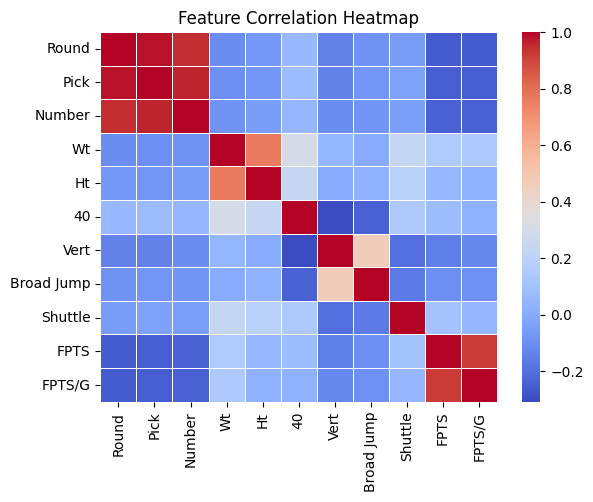

In [135]:
sns.heatmap(wrs_scaled.corr(), fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.show()

In [137]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")

Mean Squared Error (MSE): 0.027343476470862913
R² Score: -0.4616119861602783


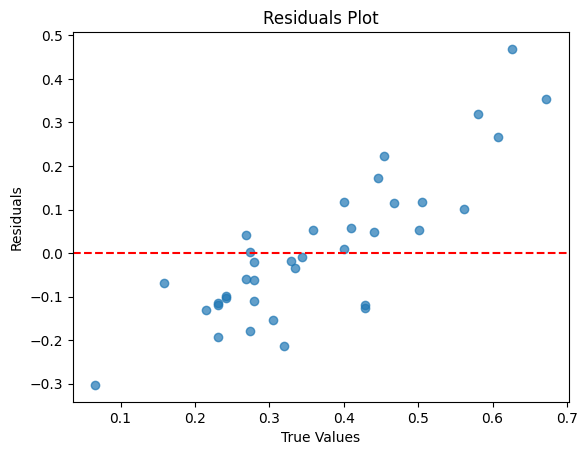

In [138]:
from sklearn.metrics import mean_squared_error
residuals = y_test.to_numpy().flat - y_pred
plt.scatter(y_test.to_numpy().flat, residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('True Values')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

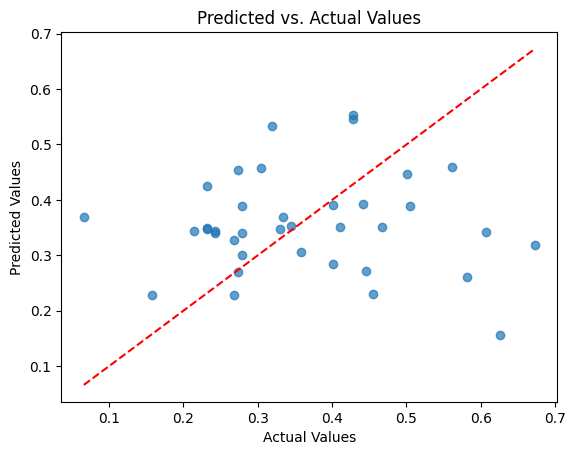

In [139]:
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. Actual Values')
plt.show()

### Code

In [119]:
wrs = merged.loc[(merged['Pos'] == 'WR') & (merged['Year'] != 2024)]

In [120]:
wrs

,Name,Pos,Year,Round,Pick,Number,Team,College,Wt,Ht,40,Bench,Vert,Broad Jump,Shuttle,3Cone,FPTS,FPTS/G,GP
424,Jaxon Smith-Njigba,WR,2023,1,20,1,Seahawks,Ohio State,196,72.63,4.52,0,35.0,125,3.93,0.00,149.8,8.8,17
426,Quentin Johnston,WR,2023,1,21,2,Chargers,Texas Christian,208,74.75,0.00,0,40.5,134,0.00,0.00,94.0,5.5,17
428,Zay Flowers,WR,2023,1,22,3,Ravens,Boston College,182,69.25,4.42,0,35.5,127,0.00,0.00,206.4,12.9,16
430,Jordan Addison,WR,2023,1,23,4,Vikings,USC,173,71.13,4.49,0,34.0,122,4.19,7.05,221.3,13.0,17
432,Jonathan Mingo,WR,2023,2,39,5,Panthers,Mississippi,220,73.75,4.46,22,39.5,129,0.00,0.00,84.8,5.7,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786,Bernard Berrian,WR,2004,3,78,12,Bears,Fresno State,183,73.00,4.58,0,38.0,128,4.18,0.00,52.3,3.3,16
788,Andre Johnson,WR,2003,1,3,2,Texans,Miami (FL),230,74.00,4.40,0,39.0,132,0.00,0.00,186.6,11.7,16
790,Anquan Boldin,WR,2003,2,54,6,Cardinals,Florida State,216,72.60,4.73,0,33.5,114,4.25,0.00,282.7,17.7,16
792,Nate Burleson,WR,2003,3,71,10,Vikings,Nevada,197,73.00,4.51,0,42.5,126,4.16,0.00,84.5,5.3,16


In [121]:
def checkForZeros():
    for col in wrs.columns[8:]:
        counts = wrs[col].value_counts()
        try:
            print(f'{col}: {counts[0]}')
        except:
            print(f'{col}: 0')

In [122]:
checkForZeros()

Wt: 0
Ht: 0
40: 11
Bench: 68
Vert: 13
Broad Jump: 16
Shuttle: 36
3Cone: 124
FPTS: 0
FPTS/G: 0
GP: 0


In [125]:
wrs = wrs.drop('Bench', axis=1)
wrs = wrs.drop('3Cone', axis=1)

In [259]:
checkForZeros()

Wt: 0
Ht: 0
40: 11
Vert: 13
Broad Jump: 16
Shuttle: 36
FPTS: 0
FPTS/G: 0
GP: 0


In [126]:
fourty_mean = wrs[wrs['40'] != 0]['40'].mean()
wrs.loc[wrs['40'] == 0, '40'] = round(fourty_mean,2)

vert_mean = wrs[wrs['Vert'] != 0]['Vert'].mean()
wrs.loc[wrs['Vert'] == 0, 'Vert'] = round(vert_mean, 1)

broad_mean = wrs[wrs['Broad Jump'] != 0]['Broad Jump'].mean()
wrs.loc[wrs['Broad Jump'] == 0, 'Broad Jump'] = int(broad_mean)

shuttle_mean = wrs[wrs['Shuttle'] != 0]['Shuttle'].mean()
wrs.loc[wrs['Shuttle'] == 0, 'Shuttle'] = round(shuttle_mean, 2)

In [262]:
checkForZeros()

Wt: 0
Ht: 0
40: 0
Vert: 0
Broad Jump: 0
Shuttle: 0
FPTS: 0
FPTS/G: 0
GP: 0


In [130]:
scaler = MinMaxScaler()
wrs_scaled = scaler.fit_transform(wrs[['Round','Pick','Number','Wt','Ht','40','Vert','Broad Jump','Shuttle','FPTS','FPTS/G']])
wrs_scaled = pd.DataFrame(wrs_scaled, columns=['Round','Pick','Number','Wt','Ht','40','Vert','Broad Jump','Shuttle','FPTS','FPTS/G'])
wrs_scaled

,Round,Pick,Number,Wt,Ht,40,Vert,Broad Jump,Shuttle,FPTS,FPTS/G
0,0.000000,0.072,0.000000,0.405405,0.555775,0.588235,0.448276,0.891473,0.100000,0.403530,0.390411
1,0.000000,0.076,0.032258,0.567568,0.765054,0.490196,0.827586,0.961240,0.366667,0.179703,0.164384
2,0.000000,0.080,0.064516,0.216216,0.222113,0.392157,0.482759,0.906977,0.366667,0.630566,0.671233
3,0.000000,0.084,0.096774,0.094595,0.407700,0.529412,0.379310,0.868217,0.316667,0.690333,0.678082
4,0.166667,0.148,0.129032,0.729730,0.666338,0.470588,0.758621,0.922481,0.366667,0.142800,0.178082
...,...,...,...,...,...,...,...,...,...,...,...
180,0.333333,0.304,0.354839,0.229730,0.592300,0.705882,0.655172,0.914729,0.308333,0.012435,0.013699
181,0.000000,0.004,0.032258,0.864865,0.691017,0.352941,0.724138,0.945736,0.366667,0.551143,0.589041
182,0.166667,0.208,0.161290,0.675676,0.552813,1.000000,0.344828,0.806202,0.366667,0.936623,1.000000
183,0.333333,0.276,0.290323,0.418919,0.592300,0.568627,0.965517,0.899225,0.291667,0.141596,0.150685


In [132]:
wrs_scaled['FPTS/G'] = np.log1p(wrs_scaled['FPTS/G'])
wrs_scaled['FPTS'] = np.log1p(wrs_scaled['FPTS'])

[0]	validation_0-rmse:0.18070
[1]	validation_0-rmse:0.18015
[2]	validation_0-rmse:0.17878
[3]	validation_0-rmse:0.17856
[4]	validation_0-rmse:0.17839
[5]	validation_0-rmse:0.18005
[6]	validation_0-rmse:0.17908
[7]	validation_0-rmse:0.17844
[8]	validation_0-rmse:0.17842
[9]	validation_0-rmse:0.17904
[10]	validation_0-rmse:0.18074
[11]	validation_0-rmse:0.17863
[12]	validation_0-rmse:0.17830
[13]	validation_0-rmse:0.17995
[14]	validation_0-rmse:0.18040
[15]	validation_0-rmse:0.18000
[16]	validation_0-rmse:0.17812
[17]	validation_0-rmse:0.17838
[18]	validation_0-rmse:0.17769
[19]	validation_0-rmse:0.18006
[20]	validation_0-rmse:0.17941
[21]	validation_0-rmse:0.18020
[22]	validation_0-rmse:0.18046
[23]	validation_0-rmse:0.18031
[24]	validation_0-rmse:0.18068
[25]	validation_0-rmse:0.18093
[26]	validation_0-rmse:0.18067
[27]	validation_0-rmse:0.18104
[28]	validation_0-rmse:0.18072
[29]	validation_0-rmse:0.18287
[30]	validation_0-rmse:0.18470
[31]	validation_0-rmse:0.18448
[32]	validation_0-

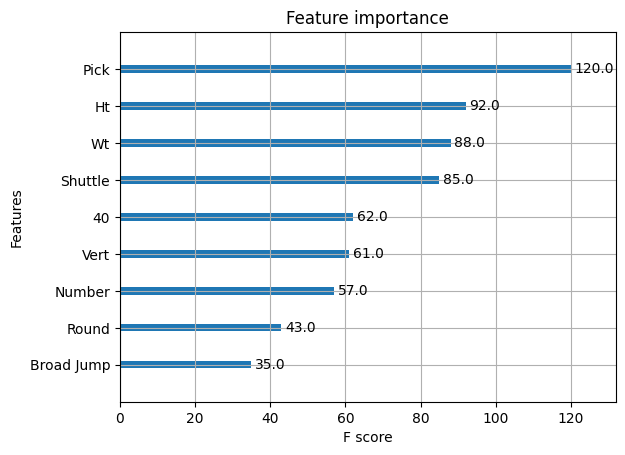

In [136]:
X = wrs_scaled[['Round','Pick','Number','Wt','Ht','40','Vert','Broad Jump','Shuttle']]
Y_FPTS = wrs_scaled[['FPTS']]
Y_FPTS_G = wrs_scaled[['FPTS/G']]
X_train_val, X_test, y_train_val, y_test = train_test_split(X, Y_FPTS_G, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.3, random_state=42)
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',  # For regression
    n_estimators=100,             # Number of trees
    learning_rate=0.1,            # Step size shrinkage
    max_depth=3,                  # Maximum tree depth
    random_state=42               # Reproducibility
)
xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)])
y_pred = xgb_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")
xgb.plot_importance(xgb_model)
plt.show()

## **Final Thoughts:**

- Based soley on combine statistics you cannot predict rookie relevance.
- This will be an ongoing project for me.
- I already have ideas to create new predictor variable such as the percentage of play types run by a coach.

## Citations:

- https://nflcombineresults.com/nflcombinedata.php?year=2003&pos=&college=#google-vignette
- https://www.drafthistory.com/index.php/positions/rb
- https://fantasydata.com/nfl/fantasy-football-leaders?scope=season&sp=2003_REG&position=wr&scoring=fpts_ppr&order_by=fpts_ppr&sort_dir=desc